In [1]:
import os
from pathlib import Path
from typing import List
from tqdm import tqdm

import numpy as np
import cv2
import pandas as ps
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A

%matplotlib inline

In [2]:
data = Path('..') / 'data'
models = Path('..') / 'logs' / 'ur34_ms_3' / 'checkpoints'

test_images = data / 'test_images'
images_list = sorted([img for img in os.listdir(str(test_images)) if img.endswith('.jpg')])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
detection_threshold = 0.25
segmentation_threshold = 0.5
min_area = [600, 600, 1000, 2000]

In [4]:
!ls ../logs/ur34_ms_3/checkpoints/

best_full.pth  stage1.10_full.pth  stage1.9.pth        stage2.39_full.pth
best.pth       stage1.10.pth	   stage2.31_full.pth  stage2.39.pth
last_full.pth  stage1.25_full.pth  stage2.31.pth
last.pth       stage1.25.pth	   stage2.33_full.pth
_metrics.json  stage1.9_full.pth   stage2.33.pth


In [5]:
segmentation_model_files = (
#     models / 'best.pth',
    '../unet18_best.pt',
)

In [6]:
def load_image(image_path: Path) -> np.ndarray:
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def tensor_from_image(image: np.ndarray) -> torch.Tensor:
    if image.dtype == np.uint8:
        image = (image / 255.).astype(np.float32)
    # (h, w, c) -> (c, w, h)
    image = np.moveaxis(image, -1, 0)
    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image)
    return image


class TestDataset(Dataset):
    def __init__(self, folder: Path, images: List[str], transforms=None):
        self.folder = folder
        self.images = images
        self.transforms = transforms
        
    def __len__(self) -> int:
        return len(self.images)
    
    def __getitem__(self, idx):
        img = load_image(self.folder / self.images[idx])
        if self.transforms is not None:
            img = self.transforms(image=img)['image']
        img = tensor_from_image(img)
        return img

In [7]:
def load_traced_model(file: Path):
    model_ = torch.jit.load(str(file))
    model_.eval()
    return model_.to(device)

In [8]:
segmentation_models = [load_traced_model(f) for f in segmentation_model_files]

In [9]:
test_dataset = TestDataset(
    test_images,
    images_list,
    A.Compose([
        A.Resize(256, 256), 
        A.Normalize()
    ])
)
detection_loader = DataLoader(test_dataset, batch_size=16, num_workers=2)

## Detection

In [10]:
# some code for filtering images for segmentation

## Segmentation

In [11]:
# shold be filtered images
imgs2segment = images_list
imgs_with_missing_masks = []

segmentation_dataset = TestDataset(
    test_images,
    imgs2segment,
    A.Compose([
        A.Resize(256, 1600), 
        A.Normalize()
    ])
)

In [12]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [13]:
with torch.no_grad():
    segments = []
    for i, img in enumerate(tqdm(segmentation_dataset)):
        filename = imgs2segment[i]
        img = img.unsqueeze(0).to(device)
        
        p = np.zeros((4, 256, 1600))
        for model in segmentation_models:
            tta = [
                torch.sigmoid(model(img)),
                # horizontal flip
                torch.sigmoid(model(img.flip(3))).flip(3),
                # vertical flip
                torch.sigmoid(model(img.flip(2))).flip(2),
                # horizontal & vertical flip
                torch.sigmoid(model(img.flip(2).flip(3))).flip(3).flip(2),
            ]
            p += torch.stack(tta).mean(dim=0).detach().squeeze(0).cpu().numpy()
        p = p / len(segmentation_models)
        p = p > segmentation_threshold
        
        # filter also using minimal predicted area
        for _cls in range(4):
            if p[_cls].sum() >= min_area[_cls]:
                segments.append( (f'{filename}_{_cls + 1}', mask2rle(p[_cls])) )
            else:
                segments.append( (f'{filename}_{_cls + 1}', '') )

                            
for filename in imgs_with_missing_masks:
    for _cls in range(4):
        segments.append( (f'{filename}_{_cls + 1}', '') )

100%|██████████| 1801/1801 [01:43<00:00, 17.39it/s]


In [14]:
submission = ps.DataFrame.from_records(segments, columns=('ImageId_ClassId', 'EncodedPixels'))
submission = submission.sort_values(by='ImageId_ClassId').reset_index(drop=True)
submission.head(30)

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,
1,004f40c73.jpg_2,
2,004f40c73.jpg_3,
3,004f40c73.jpg_4,
4,006f39c41.jpg_1,
5,006f39c41.jpg_2,
6,006f39c41.jpg_3,
7,006f39c41.jpg_4,
8,00b7fb703.jpg_1,
9,00b7fb703.jpg_2,


## Checking

In [15]:
df = submission.copy()
df.head()

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,
1,004f40c73.jpg_2,
2,004f40c73.jpg_3,
3,004f40c73.jpg_4,
4,006f39c41.jpg_1,


In [16]:
df['Image'] = df['ImageId_ClassId'].map(lambda x: x.split('_')[0])
df['Class'] = df['ImageId_ClassId'].map(lambda x: x.split('_')[1])
df['empty'] = df['EncodedPixels'].map(lambda x: x == '')
df[df['empty'] == False]['Class'].value_counts()

3    587
4    131
1    114
2     49
Name: Class, dtype: int64

In [17]:
def rle2mask(s, imgshape) -> np.ndarray:
    """
    Convert rle of image to a mask (2 dimensional np.ndarray).
    """
    rows, cols = imgshape[0], imgshape[1]
    rle = np.array([int(n) for n in s.split()])
    rlePairs = rle.reshape(-1, 2)
    img = np.zeros(rows * cols, dtype=np.uint8)
    for index, length in rlePairs:
        index -= 1
        img[index : index + length] = 255
    img = img.reshape(cols, rows)
    img = img.T
    return img

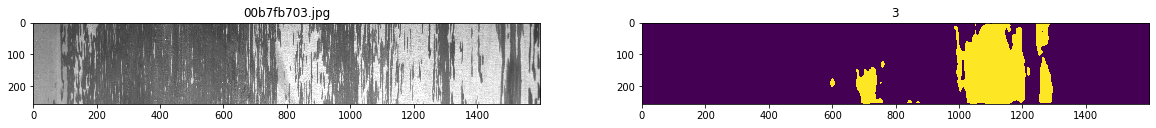

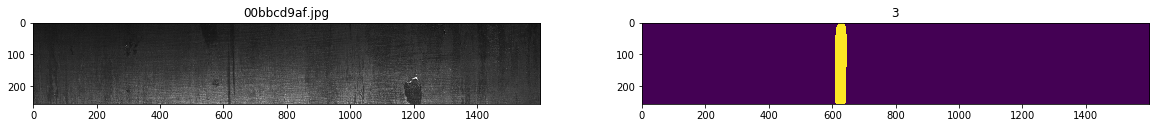

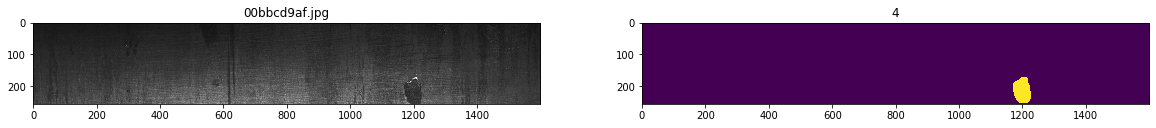

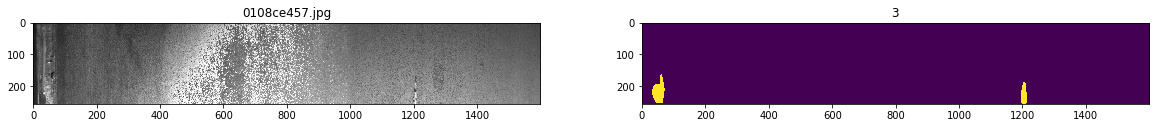

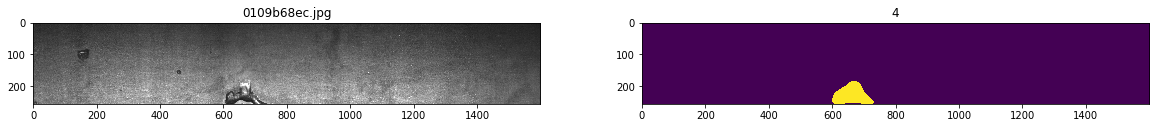

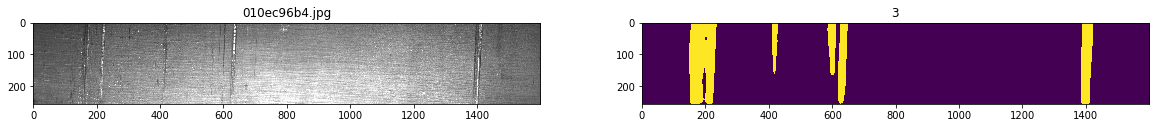

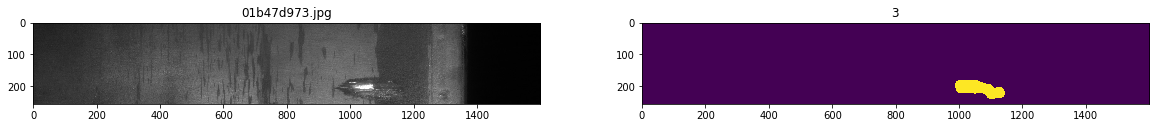

In [18]:
df = submission.copy()[:40]
df['Image'] = df['ImageId_ClassId'].map(lambda x: x.split('_')[0])
df['Class'] = df['ImageId_ClassId'].map(lambda x: x.split('_')[1])

for row in df.itertuples():
    img_path = str(test_images / row.Image)
    img = cv2.imread(img_path)
    if isinstance(row.EncodedPixels, str):
        mask = rle2mask(row.EncodedPixels, (256, 1600))
    else:
        mask = np.zeros((256, 1600))

    if mask.sum() == 0:
        continue
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 60))
    axes[0].imshow(img / 255)
    axes[1].imshow(mask * 60)
    axes[0].set_title(row.Image)
    axes[1].set_title(row.Class)
    plt.show()